In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import pandas as pd




In [ ]:
df = pd.read_csv('./projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1572006141.7793334_concat_report_final.csv', index_col=0)

In [ ]:
df.shape

In [ ]:
feats_from_paper_for_individual_test = [['age', 'sex', 'bmi_numeric'],
             ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'], ['hypertension'], ['triglyceride'],
             ['blood_pressure_diastolic', 'blood_pressure_systolic'],
             ['cholesterol_hdl', 'cholesterol_ldl', 'cholesterol_total'],
             ['mri_liver_fat_artifacts', 'mri_liver_fat_lobus_dexter', 
              'mri_liver_fat_lobus_sinister', 'mri_liver_fat_portal_vein'],
             ['meds_lipoprotein_lowering', 'meds_antihypertensive'],
             ['smoker_former', 'smoker_non_smoker', 'smoker_regular'], ['alcohol_g_day']]

flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
X, y = df[flatten(feats_from_paper_for_individual_test)], df.seg_liver

In [ ]:
X_new = SelectKBest(chi2, k=2).fit_transform(X, y)

In [ ]:
!pip install scikit-image

In [1]:
import numpy as np
from skimage.measure import label   
import matplotlib.pyplot as plt
%matplotlib inline

def getLargestCC(segmentation):
    labels = label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

In [2]:
import nibabel as nb
import glob

In [3]:
data_nifty = nb.load('/home/abhijit/Jyotirmay/my_thesis/projects/full_bayesian/outs/full_bayesian_KORA_v2/full_bayesian_KORA_v2_predictions_KORA/KORA2452190_seg.nii.gz')

In [4]:
samples_ = glob.glob('/home/abhijit/Jyotirmay/my_thesis/projects/full_bayesian/outs/full_bayesian_KORA_v2/full_bayesian_KORA_v2_predictions_KORA/KORA2452190_samples/*')

In [5]:
vol_outs = []
for s in samples_:
    vol_outs.append(nb.load(s).get_fdata())


In [6]:
d = data_nifty.get_fdata()
no_samples = d.shape[0]
samples = np.random.choice(len(data_nifty.get_fdata()), no_samples, replace=False)
print(samples)

[10 43 36 53 20 13 33 50 22  2 38  8 49 57  7 54 41 17 25 48  1 23 37 35
 29 11 16 26 39  5 24  9 52 12  0 34 19  4 15 44 18 27 32 40 31 21 45  6
  3 51 30 55 56 28 14 42 46 47]


In [7]:
step = no_samples//len(samples_)+1
counter = 0

vol_outs = np.array(vol_outs)
vol_out = np.zeros((no_samples, d.shape[-2], d.shape[-1]))
print(vol_out.shape, np.unique(vol_out))
for i in range(0, no_samples, step):
    vol_out[i:i+step] = vol_outs[counter, i:i+step]
    print(',')
    counter += 1

print(vol_out.shape, d.shape,  np.unique(vol_out), np.unique(vol_outs))

(58, 256, 144) [0.]
,
,
,
,
,
,
,
,
,
,
(58, 256, 144) (58, 256, 144) [0. 1. 2.] [0. 1. 2.]


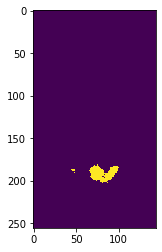

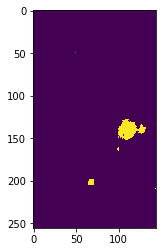

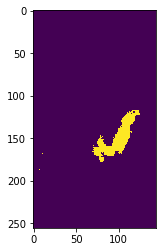

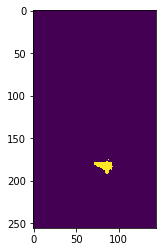

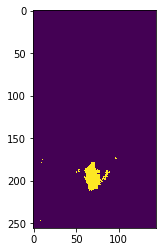

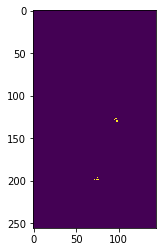

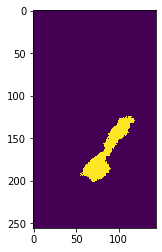

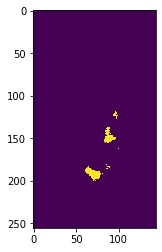

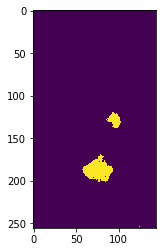

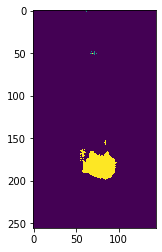

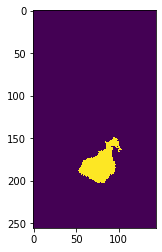

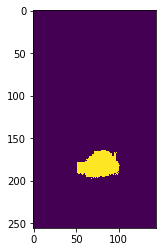

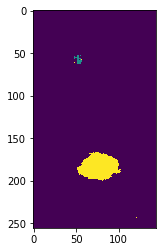

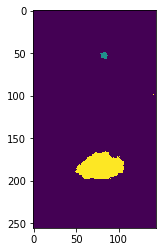

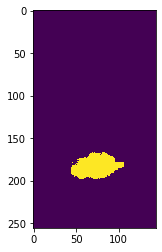

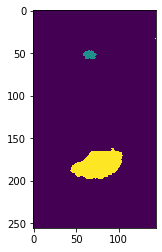

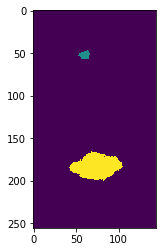

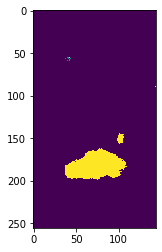

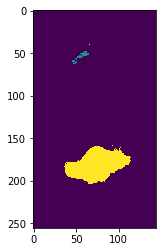

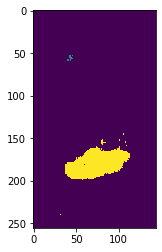

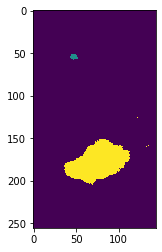

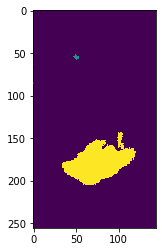

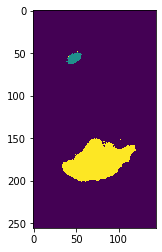

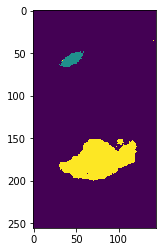

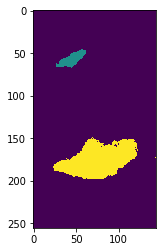

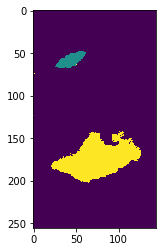

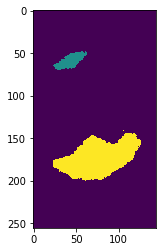

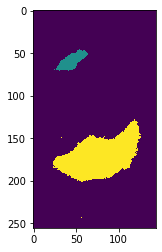

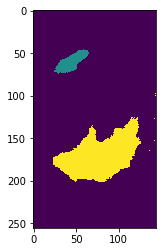

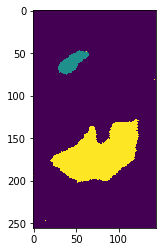

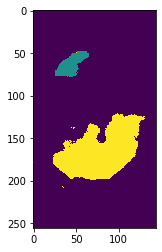

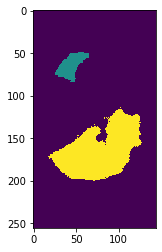

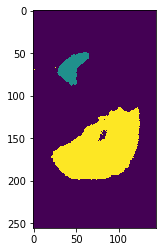

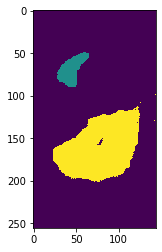

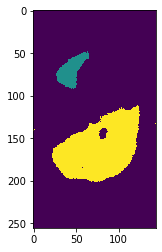

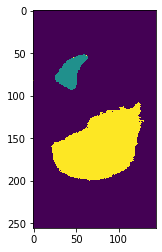

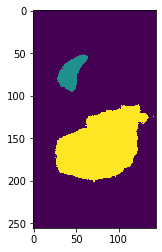

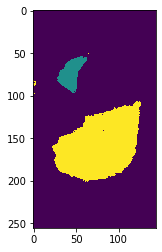

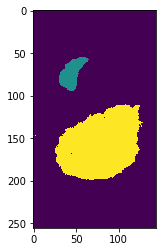

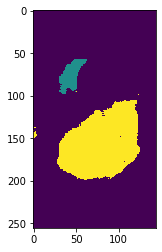

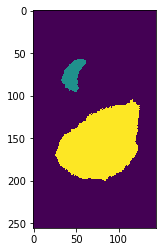

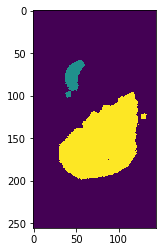

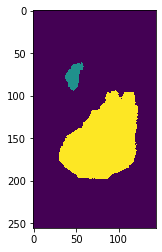

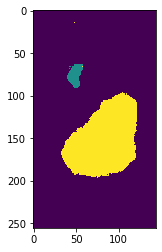

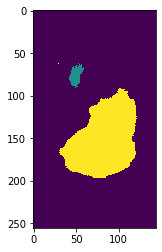

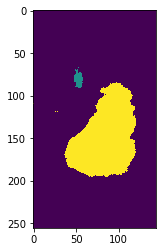

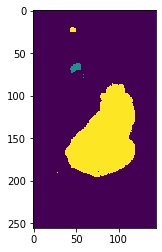

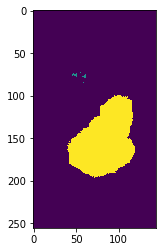

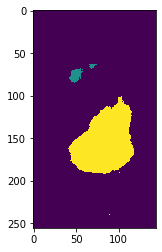

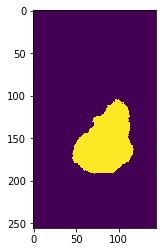

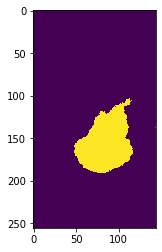

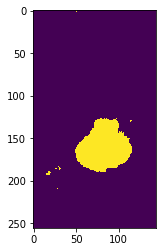

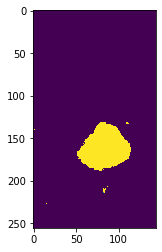

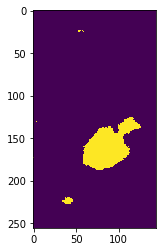

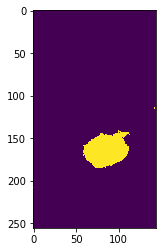

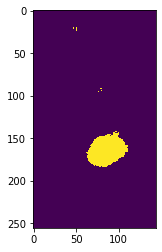

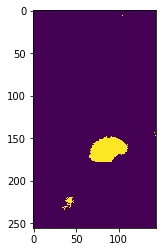

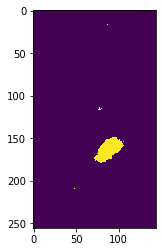

In [8]:
for i in range(vol_out.shape[0]):
    plt.imshow(vol_out[i])
    plt.show()

In [9]:
from utils.surface_distance import compute_surface_distances, compute_surface_overlap_at_tolerance

In [10]:
def dice_surface_distance_perclass(vol_output, ground_truth, no_samples=40, mode='train'):
    surface_distance_perclass = np.zeros((3, 2))
    organ_tolerances = [1.0, 3.0, 3.0]
    if mode == 'train':
        #samples = np.random.choice(len(vol_output), no_samples)
        #print(vol_output.shape, ground_truth.shape)
        #vol_output, ground_truth = vol_output[samples], ground_truth[samples]
        print(vol_output.shape, ground_truth.shape)
    for i in range(3):
        GT = (ground_truth == i)
        Pred = (vol_output == i)

        surface_dis = compute_surface_distances(GT, Pred, [2,2,3])
        avg_surface_distance = compute_surface_overlap_at_tolerance(surface_dis, organ_tolerances[i])
        surface_distance_perclass[i] = avg_surface_distance
    return surface_distance_perclass

In [11]:
data = data_nifty.get_fdata()
'''for i in range(data.shape[0]):
    plt.imshow(data[i])
    plt.show()
   ''' 
all_data = data.copy()

liver_seg =np.zeros_like(data)
spleen_seg = np.zeros_like(data)

In [12]:

cc = getLargestCC(data)
liver_seg[cc] = 2
print(liver_seg.shape, np.unique(liver_seg))

(58, 256, 144) [0. 2.]


In [13]:
data[cc] = 0
ss = getLargestCC(data)
spleen_seg[ss] = 1
print(spleen_seg.shape, np.unique(spleen_seg))


(58, 256, 144) [0. 1.]


In [14]:
gt = liver_seg + spleen_seg

In [15]:
samples

array([10, 43, 36, 53, 20, 13, 33, 50, 22,  2, 38,  8, 49, 57,  7, 54, 41,
       17, 25, 48,  1, 23, 37, 35, 29, 11, 16, 26, 39,  5, 24,  9, 52, 12,
        0, 34, 19,  4, 15, 44, 18, 27, 32, 40, 31, 21, 45,  6,  3, 51, 30,
       55, 56, 28, 14, 42, 46, 47])

In [ ]:
gt = gt[np.sort(samples)]


In [ ]:
all_data = all_data[np.sort(samples)]

In [16]:
dice_surface_distance_perclass(vol_out, gt)

(58, 256, 144) (58, 256, 144)


array([[0.96209603, 0.85050616],
       [0.99907433, 0.74989974],
       [0.99111714, 0.72033553]])

In [ ]:
print(gt.shape, np.unique(gt))

In [17]:
dice_surface_distance_perclass(all_data, gt)

(58, 256, 144) (58, 256, 144)


array([[1.        , 0.98508037],
       [1.        , 0.89980649],
       [1.        , 0.94050003]])

In [ ]:
for i in range(all_data.shape[0]):
    plt.imshow(all_data[i])
    plt.show()

In [ ]:
for i in range(gt.shape[0]):
    plt.imshow(gt[i])
    plt.show()

In [ ]:
data_liver = data[cc]
all_data = data
data[cc]=0
ss = getLargestCC(data)
data_spleen = data[ss]
print(np.unique(data[ss]))

In [ ]:
all_liver = all_data[all_data == 2]
all_spleen = all_data[all_data ==1]
np.count_nonzero(data_spleen)/np.count_nonzero(all_spleen)

In [ ]:
print(np.count_nonzero(data_liver)/np.count_nonzero(all_liver))

In [ ]:
a = np.array([1,2,3])
a[[True, False, False]]